# Batch Simulation

### Load Libraries

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import cobra
import cplex

In [2]:
def EFlux2(model, Transcriptomics):
    
    mets = [m.id for m in model.metabolites]
    rxns = [r.id for r in model.reactions]
    nrow = len(mets)
    ncol = len(rxns)

    c = [r.objective_coefficient for r in model.reactions]

    gpr_dict = dict()
    for r in model.reactions:
        if r.gene_reaction_rule:
            temp = set()
            for x in [x.strip('() ') for x in r.gene_reaction_rule.split(' or ')]:
                temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
            gpr_dict[r.id] = temp

    for r in model.reactions:
        if r.lower_bound == -1000.0:
            r.lower_bound = -np.Inf
        if r.upper_bound == 1000.0:
            r.upper_bound = np.Inf

    lb = []
    ub = []
    for r in model.reactions:
        if r.gene_reaction_rule:
            t = np.sum([np.min([Transcriptomics.loc[g] if g in Transcriptomics.index 
                                else np.array([np.Inf]) for g in p])
                        for p in gpr_dict[r.id]])
            if r.lower_bound < 0.0:
                lb.append(-t)
            else:
                lb.append(r.lower_bound)
            if r.upper_bound > 0.0:
                ub.append(t)
            else:
                ub.append(r.upper_bound)
        else:
            lb.append(r.lower_bound)
            ub.append(r.upper_bound)

    EFlux2 = cplex.Cplex()
    EFlux2.set_results_stream(None)
    EFlux2.parameters.simplex.tolerances.optimality.set(1e-9)
    EFlux2.parameters.simplex.tolerances.feasibility.set(1e-9)

    EFlux2.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
    EFlux2.variables.add(obj=c, lb=lb, ub=ub, names=rxns)
    for r in model.reactions:
        for m, v in r.metabolites.items():
            EFlux2.linear_constraints.set_coefficients(m.id, r.id, v)

    EFlux2.objective.set_sense(EFlux2.objective.sense.maximize)
    EFlux2.solve()
    
    Q = [1.0 for r in model.reactions]
    
    EFlux2_min = cplex.Cplex()
    EFlux2_min.set_results_stream(None)
    EFlux2_min.parameters.simplex.tolerances.optimality.set(1e-9)
    EFlux2_min.parameters.simplex.tolerances.feasibility.set(1e-9)

    EFlux2_min.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
    EFlux2_min.variables.add(obj=[0]*ncol, lb=lb, ub=ub, names=rxns)
    for r in model.reactions:
        for m, v in r.metabolites.items():
            EFlux2_min.linear_constraints.set_coefficients(m.id, r.id, v)

    EFlux2_min.variables.set_lower_bounds(biomass, 1.0*EFlux2.solution.get_objective_value())
    EFlux2_min.objective.set_quadratic(Q)
    EFlux2_min.objective.set_sense(EFlux2_min.objective.sense.minimize)
    EFlux2_min.solve()
    
    sol = type('',(),{})()
    sol = pd.Series(data=EFlux2_min.solution.get_values(), index=rxns)
    sol.objective_value = (EFlux2.solution.get_objective_value(),
                           EFlux2_min.solution.get_objective_value())
    sol.status = (EFlux2.solution.get_status_string(),
                  EFlux2_min.solution.get_status_string())
    
    return(sol)

def SPOT(model, Transcriptomics):
    
    mets = [m.id for m in model.metabolites]
    rxns = [r.id for r in model.reactions]
    nrow = len(mets)
    ncol = len(rxns)

    rev_rxns = ['rev_'+r.id for r in model.reactions if r.reversibility]
    rev_ncol = len(rev_rxns)

    gpr_dict = dict()
    for r in model.reactions:
        if r.gene_reaction_rule:
            temp = set()
            for x in [x.strip('() ') for x in r.gene_reaction_rule.split(' or ')]:
                temp.add(frozenset(y.strip('() ') for y in x.split(' and ')))
            gpr_dict[r.id] = temp

    lb = [0.0 if r.reversibility else r.lower_bound for r in model.reactions] + [0.0 for r in model.reactions if r.reversibility]
    ub = [r.upper_bound for r in model.reactions] + [-r.lower_bound for r in model.reactions if r.reversibility]
        
    c = []
    for r in model.reactions:
        if r.gene_reaction_rule:
            t = np.sum([np.min([Transcriptomics.loc[g] if g in Transcriptomics.index 
                                else np.array([np.Inf]) for g in p])
                        for p in gpr_dict[r.id]])
            if t == np.Inf:
                t = 0
            c.append(t)
        else:
            c.append(0.0)
    for r in model.reactions:
        if r.reversibility:
            if r.gene_reaction_rule:
                t = np.sum([np.min([Transcriptomics.loc[g] if g in Transcriptomics.index 
                                    else np.array([np.Inf]) for g in p])
                            for p in gpr_dict[r.id]])
                if t == np.Inf:
                    t = 0
                c.append(t)
            else:
                c.append(0.0)

    SPOT = cplex.Cplex()
    SPOT.set_results_stream(None)
    SPOT.parameters.simplex.tolerances.optimality.set(1e-9)
    SPOT.parameters.simplex.tolerances.feasibility.set(1e-9)

    SPOT.linear_constraints.add(rhs=[0]*nrow, senses='E'*nrow, names=mets)
    SPOT.variables.add(obj=c, lb=lb, ub=ub, names=rxns+rev_rxns)
    for r in model.reactions:
        for m, v in r.metabolites.items():
            SPOT.linear_constraints.set_coefficients(m.id, r.id, v)
    for r in model.reactions:
        if r.reversibility:
            for m, v in r.metabolites.items():
                SPOT.linear_constraints.set_coefficients(m.id, 'rev_'+r.id, -v)
    SPOT.quadratic_constraints.add(quad_expr=[rxns+rev_rxns, rxns+rev_rxns, [1]*len(c)],
                                   sense='L', rhs=100000.0, name='L2norm')
    SPOT.objective.set_sense(SPOT.objective.sense.maximize)
    SPOT.solve()
    SPOT_sol = SPOT.solution.get_objective_value()

    sol = type('',(),{})()
    temp = pd.Series(data=SPOT.solution.get_values(), index=rxns+rev_rxns)
    flux = temp.loc[rxns]
    flux_rev = temp.loc[rev_rxns]
    for r in model.reactions:
        if r.reversibility:
            flux.loc[r.id] = flux.loc[r.id] - flux_rev.loc['rev_'+r.id]
    sol = flux
    sol.objective_value = SPOT.solution.get_objective_value()
    sol.status = SPOT.solution.get_status_string()
    
    return(sol)

### Load a metabolic model

In [3]:
model = cobra.io.load_json_model("iML1515.json")

In [4]:
model

Name,iML1515
Memory address,0x07fcd010f1860
Number of metabolites,1877
Number of reactions,2712
Objective expression,-1.0*BIOMASS_Ec_iML1515_core_75p37M_reverse_35685 + 1.0*BIOMASS_Ec_iML1515_core_75p37M
Compartments,"cytosol, extracellular space, periplasm"


In [5]:
biomass = 'BIOMASS_Ec_iML1515_core_75p37M'

In [6]:
model.medium

{'EX_ca2_e': 1000.0,
 'EX_cl_e': 1000.0,
 'EX_co2_e': 1000.0,
 'EX_cobalt2_e': 1000.0,
 'EX_cu2_e': 1000.0,
 'EX_fe2_e': 1000.0,
 'EX_fe3_e': 1000.0,
 'EX_glc__D_e': 10.0,
 'EX_h2o_e': 1000.0,
 'EX_h_e': 1000.0,
 'EX_k_e': 1000.0,
 'EX_mg2_e': 1000.0,
 'EX_mn2_e': 1000.0,
 'EX_mobd_e': 1000.0,
 'EX_na1_e': 1000.0,
 'EX_nh4_e': 1000.0,
 'EX_ni2_e': 1000.0,
 'EX_o2_e': 1000.0,
 'EX_pi_e': 1000.0,
 'EX_sel_e': 1000.0,
 'EX_slnt_e': 1000.0,
 'EX_so4_e': 1000.0,
 'EX_tungs_e': 1000.0,
 'EX_zn2_e': 1000.0}

In [7]:
model.solver

In [8]:
model.solver = 'cplex'
sol = model.optimize()
print(sol.status, sol.objective_value)

optimal 0.876997214426973


In [9]:
sol = cobra.flux_analysis.pfba(model)
print(sol.status, sol[biomass])

optimal 0.876997214426973


In [10]:
Transcriptomics = pd.read_csv('ishii-trans-1.csv', index_col=0, header=None)
Transcriptomics.head()

,1
0,
b0957,45.278681
b0929,42.173087
b1480,38.351485
b3299,29.201456
b2093,36.778437


In [11]:
sol = EFlux2(model,Transcriptomics[1])
print(sol.status, sol.objective_value)

('optimal', 'optimal') (0.21407999833428526, 988.7483913155061)


In [12]:
sol = SPOT(model,Transcriptomics[1])
print(sol.status, sol[biomass], sol.objective_value)

optimal -1.1006196102415449e-06 494551.1644285894


In [13]:
print('Uptake rates')
for x in model.exchanges:
    if sol[x.id] < -1e-6:
        print(x.id, sol[x.id])
print()
print('Secretion rates')
for x in model.exchanges:
    if sol[x.id] > 1e-6:
        print(x.id, sol[x.id])

Uptake rates
EX_fe2_e -0.3855336033134979
EX_glc__D_e -1.2143225160296032
EX_dgsn_e -1.0131261304096836e-06
EX_din_e -1.002453364891099e-06
EX_amp_e -1.0331307150116402e-06
EX_gthrd_e -1.0098151992833501e-06
EX_adn_e -1.0211063219288138e-06
EX_dad_2_e -1.0333153410731049e-06
EX_cu2_e -1.3810385990288727e-06
EX_23camp_e -1.0256401730988357e-06
EX_23cgmp_e -1.0091693372632283e-06
EX_3amp_e -1.0246057854439925e-06
EX_3gmp_e -1.0078018939953799e-06
EX_imp_e -1.0137678421125588e-06
EX_gmp_e -1.0201701318008753e-06
EX_so4_e -1.5391106448156295e-06
EX_gsn_e -1.0027375364088666e-06
EX_o2_e -3.203838251713914
EX_LalaDgluMdapDala_e -1.019566587417092e-06
EX_anhgm_e -1.015334327197908e-06
EX_damp_e -1.0399709853062315e-06
EX_dimp_e -1.0174725284437678e-06
EX_dgmp_e -1.0251480340118395e-06

Secretion rates
EX_pi_e 4.8941134616035595e-05
EX_h_e 2.5400416182610823
EX_ac_e 0.9898048921499839
EX_fe3_e 0.3855333512269465
EX_glcn_e 1.3690181447450287e-06
EX_glyc_e 5.07912870430075e-06
EX_rib__D_e 1.0014

### Define medium and initial concentrations

In [14]:
volume = 1.0
comp = ['glc__D_e', 'nh4_e', 'pi_e', 'so4_e', 'mg2_e', 'k_e', 'na1_e', 'cl_e']
subs0 = [22.203, 18.695, 69.454, 2.0, 2.0, 21.883, 103.7, 27.25] # in mM
cell0 = 0.01 # in gDW/L
pd.DataFrame(index=comp, data=subs0, columns=['mM'])

,mM
glc__D_e,22.203
nh4_e,18.695
pi_e,69.454
so4_e,2.000
mg2_e,2.000
k_e,21.883
na1_e,103.700
cl_e,27.250


In [15]:
subs_ext = {r.id: r.reactants[0].id for r in model.exchanges if r.reactants[0].id in comp}
subs_ext

{'EX_cl_e': 'cl_e',
 'EX_glc__D_e': 'glc__D_e',
 'EX_k_e': 'k_e',
 'EX_mg2_e': 'mg2_e',
 'EX_na1_e': 'na1_e',
 'EX_nh4_e': 'nh4_e',
 'EX_pi_e': 'pi_e',
 'EX_so4_e': 'so4_e'}

In [16]:
prod_ext = {r.id: r.reactants[0].id for r in model.exchanges if r.upper_bound > 0.0}
prod_ext

{'DM_4crsol_c': '4crsol_c',
 'DM_5drib_c': '5drib_c',
 'DM_aacald_c': 'aacald_c',
 'DM_amob_c': 'amob_c',
 'DM_mththf_c': 'mththf_c',
 'DM_oxam_c': 'oxam_c',
 'EX_12ppd__R_e': '12ppd__R_e',
 'EX_12ppd__S_e': '12ppd__S_e',
 'EX_14glucan_e': '14glucan_e',
 'EX_15dap_e': '15dap_e',
 'EX_23camp_e': '23camp_e',
 'EX_23ccmp_e': '23ccmp_e',
 'EX_23cgmp_e': '23cgmp_e',
 'EX_23cump_e': '23cump_e',
 'EX_23dappa_e': '23dappa_e',
 'EX_26dap__M_e': '26dap__M_e',
 'EX_2ddglcn_e': '2ddglcn_e',
 'EX_2dglc_e': '2dglc_e',
 'EX_34dhpac_e': '34dhpac_e',
 'EX_3amp_e': '3amp_e',
 'EX_3cmp_e': '3cmp_e',
 'EX_3gmp_e': '3gmp_e',
 'EX_3hcinnm_e': '3hcinnm_e',
 'EX_3hpp_e': '3hpp_e',
 'EX_3hpppn_e': '3hpppn_e',
 'EX_3ump_e': '3ump_e',
 'EX_4abut_e': '4abut_e',
 'EX_4abzglu_e': '4abzglu_e',
 'EX_4hoxpacd_e': '4hoxpacd_e',
 'EX_5dglcn_e': '5dglcn_e',
 'EX_5mtr_e': '5mtr_e',
 'EX_LalaDgluMdapDala_e': 'LalaDgluMdapDala_e',
 'EX_LalaDgluMdap_e': 'LalaDgluMdap_e',
 'EX_LalaDglu_e': 'LalaDglu_e',
 'EX_LalaLglu_e': 'Lal

### Set time interval and concentration profiles

In [17]:
t0 = 0.0
tf = 24.0
pts = 13
tspan = np.linspace(t0, tf, pts)
delt = tspan[1] - tspan[0]
cell = pd.Series(index=tspan)
cell[t0] = cell0
subs = pd.DataFrame(index=tspan, columns=comp)
subs.loc[t0] = subs0
prod = pd.DataFrame(index=tspan, columns=prod_ext.values())
prod.loc[t0] = 0.0

### Solve pFBA at each time interval and update concentrations

In [18]:
with model:
    for t in tspan:
        for k, v in subs_ext.items():
            model.reactions.get_by_id(k).lower_bound = max(model.reactions.get_by_id(k).lower_bound,
                                                           -subs.loc[t,v]*volume/cell[t]/delt)
        sol = model.optimize()
        #sol = cobra.flux_analysis.pfba(model)
        mu = sol[biomass]
        print(t, sol.status, mu)
        if sol.status == 'optimal' and mu > 1e-6:
            cell[t+delt] = cell[t]*np.exp(mu*delt)
            for k, v in subs_ext.items():
                subs.loc[t+delt,v] = max(subs.loc[t,v]-sol[k]/mu*cell[t]*(1-np.exp(mu*delt)),0.0)
            for k, v in prod_ext.items():
                if sol[k] > 0:
                    if v in prod.columns:
                        prod.loc[t+delt,v] = prod.loc[t,v]-sol[k]/mu*cell[t]*(1-np.exp(mu*delt))
                    else:
                        prod.loc[0:t,v] = 0
                        prod.loc[t+delt,v] = prod.loc[t,v]-sol[k]/mu*cell[t]*(1-np.exp(mu*delt))
        else:
            #break
            cell[t+delt] = cell[t]
            for k, v in subs_ext.items():
                subs.loc[t+delt,v] = subs.loc[t,v]
            for k, v in prod_ext.items():
                prod.loc[t+delt,v] = prod.loc[t,v]

t = 24
cell = cell[0:t]
subs = subs.loc[0:t]
prod = prod.loc[0:t, prod.columns[prod.max() > 0.0]]

0.0 optimal 0.8769972144269672
2.0 optimal 0.8769972144269672
4.0 optimal 0.8769972144269672


cobra/util/solver.py:403 UserWarning: solver status is 'infeasible'


6.0 infeasible -0.030930228137858007
8.0 infeasible -0.030930228137858007
10.0 infeasible -0.030930228137858007
12.0 infeasible -0.030930228137858007
14.0 infeasible -0.030930228137858007
16.0 infeasible -0.030930228137858007
18.0 infeasible -0.030930228137858007
20.0 infeasible -0.030930228137858007
22.0 infeasible -0.030930228137858007
24.0 infeasible -0.030930228137858007


### Plot cell mass and concentration profiles

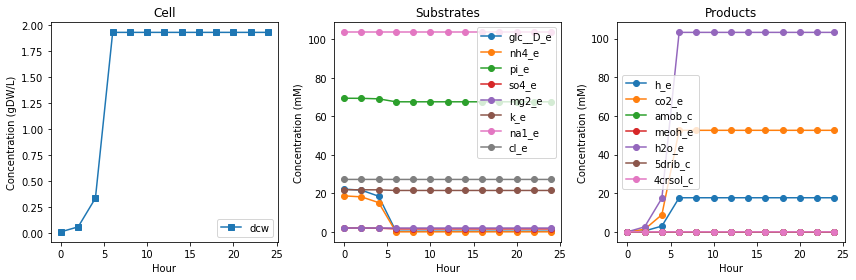

In [19]:
fig, ax = plt.subplots(figsize=(12,4), ncols=3, nrows=1)
cell.plot(ax=ax[0], style='s-', title='Cell', label='dcw', legend=True)
ax[0].set_xlabel("Hour")
ax[0].set_ylabel("Concentration (gDW/L)")
subs.plot(ax=ax[1], style='o-', title='Substrates')
ax[1].set_xlabel("Hour")
ax[1].set_ylabel("Concentration (mM)")
prod.plot(ax=ax[2], style='o-', title='Products')
ax[2].set_xlabel("Hour")
ax[2].set_ylabel("Concentration (mM)")
plt.tight_layout()

### Set time interval and concentration profiles

In [20]:
t0 = 0.0
tf = 24.0
pts = 13
tspan = np.linspace(t0, tf, pts)
delt = tspan[1] - tspan[0]
cell = pd.Series(index=tspan)
cell[t0] = cell0
subs = pd.DataFrame(index=tspan, columns=comp)
subs.loc[t0] = subs0
prod = pd.DataFrame(index=tspan, columns=prod_ext.values())
prod.loc[t0] = 0.0

### Solve EFlux2 at each time interval and update concentrations

In [21]:
with model:
    for t in tspan:
        for k, v in subs_ext.items():
            model.reactions.get_by_id(k).lower_bound = max(model.reactions.get_by_id(k).lower_bound,
                                                           -subs.loc[t,v]*volume/cell[t]/delt)
        sol = EFlux2(model,Transcriptomics[1])
        #sol = SPOT(model,Transcriptomics[t])
        mu = sol[biomass]
        print(t, sol.status, mu)
        if sol.status == ('optimal','optimal') and mu > 1e-6:
            cell[t+delt] = cell[t]*np.exp(mu*delt)
            for k, v in subs_ext.items():
                subs.loc[t+delt,v] = max(subs.loc[t,v]-sol[k]/mu*cell[t]*(1-np.exp(mu*delt)),0.0)
            for k, v in prod_ext.items():
                if sol[k] > 0:
                    if v in prod.columns:
                        prod.loc[t+delt,v] = prod.loc[t,v]-sol[k]/mu*cell[t]*(1-np.exp(mu*delt))
                    else:
                        prod.loc[0:t,v] = 0
                        prod.loc[t+delt,v] = prod.loc[t,v]-sol[k]/mu*cell[t]*(1-np.exp(mu*delt))
        else:
            #break
            cell[t+delt] = cell[t]
            for k, v in subs_ext.items():
                subs.loc[t+delt,v] = subs.loc[t,v]
            for k, v in prod_ext.items():
                prod.loc[t+delt,v] = prod.loc[t,v]

cell = cell[0:t]
subs = subs.loc[0:t]
prod = prod.loc[0:t, prod.columns[prod.max() > 0.1]]

0.0 ('optimal', 'optimal') 0.21407999833428543
2.0 ('optimal', 'optimal') 0.21407999833428543
4.0 ('optimal', 'optimal') 0.2140799983342853
6.0 ('optimal', 'optimal') 0.21407999833428554
8.0 ('optimal', 'optimal') 0.2140799983342855
10.0 ('optimal', 'optimal') 0.21407999833428545
12.0 ('optimal', 'optimal') 0.21407999833428545
14.0 ('optimal', 'optimal') 0.21407999833428445
16.0 ('optimal', 'optimal') 0.2140799983342877
18.0 ('optimal', 'optimal') 0.21407999833428767
20.0 ('optimal', 'optimal') 0.20259004050990442
22.0 ('infeasible', 'non-optimal') -0.029206586869131933
24.0 ('infeasible', 'non-optimal') -0.029206586869131933


### Plot cell mass and concentration profiles

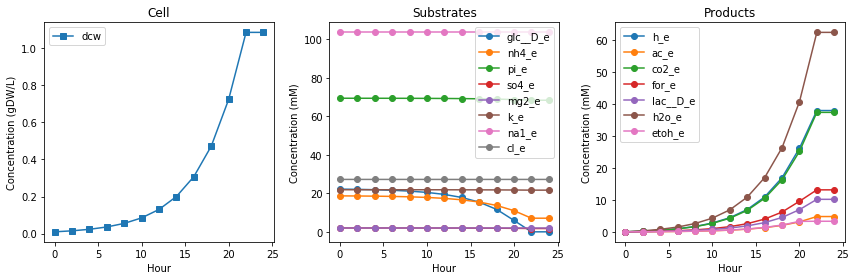

In [22]:
fig, ax = plt.subplots(figsize=(12,4), ncols=3, nrows=1)
cell.plot(ax=ax[0], style='s-', title='Cell', label='dcw', legend=True)
ax[0].set_xlabel("Hour")
ax[0].set_ylabel("Concentration (gDW/L)")
subs.plot(ax=ax[1], style='o-', title='Substrates')
ax[1].set_xlabel("Hour")
ax[1].set_ylabel("Concentration (mM)")
prod.plot(ax=ax[2], style='o-', title='Products')
ax[2].set_xlabel("Hour")
ax[2].set_ylabel("Concentration (mM)")
plt.tight_layout()